# 【ラベルの定常性向上】
株式市場は刻一刻と状況が変化していきます。例えばコロナショックのあった2020年3月と、米大統領選の影響で大きく上昇した2020年11月では、当然個別銘柄の値動きの挙動も大きく異なります。

チュートリアルにおける訓練データの期間は、2016年1月～2017年12月となっています。この2年間において、株式市場は様々な市況を経ています。このとき、labelの分布がどのように推移しているのか、確認する必要があります。

In [2]:
import pickle
import datetime
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DayLocator, DateFormatter
from mpl_finance import candlestick2_ohlc, volume_overlay

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from tqdm.auto import tqdm

%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120
warnings.simplefilter('ignore')

In [3]:
def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj,f)

def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

In [4]:
# チュートリアルのtrain_X, val_X, test_X, train_y, val_y, test_y　私はpickleで保存しています
# ""の中身はご自身の環境に合わせて定義してください
train_X = pickle_load("...")
val_X = pickle_load("...")
test_X = pickle_load("...")
train_y = pickle_load("...")
val_y = pickle_load("...")
test_y = pickle_load("...")

In [5]:
# データセットの読み込み
# ""の中身はご自身の環境に合わせて定義してください
dataset_dir="..."
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv",
    "stock_price": f"{dataset_dir}/stock_price.csv",
    "stock_fin": f"{dataset_dir}/stock_fin.csv",
    "stock_labels": f"{dataset_dir}/stock_labels.csv",
}

dfs = {}
for k, v in inputs.items():
    dfs[k] = pd.read_csv(v)

## 図1.ラベルの分布の推移
一例として、訓練データを2016年1月から四半期毎に区切り、その分布の推移を見てみます。

In [6]:
def plot_hist(datas, dts):
    fig,ax = plt.subplots(nrows=4,ncols=2,figsize=(18,15))
    for i in range(8):
        ax[int(i/2), i%2].hist(datas[i], bins=50, range=(-0.25, 0.5))
        ax[int(i/2), i%2].set_title(dts[i])

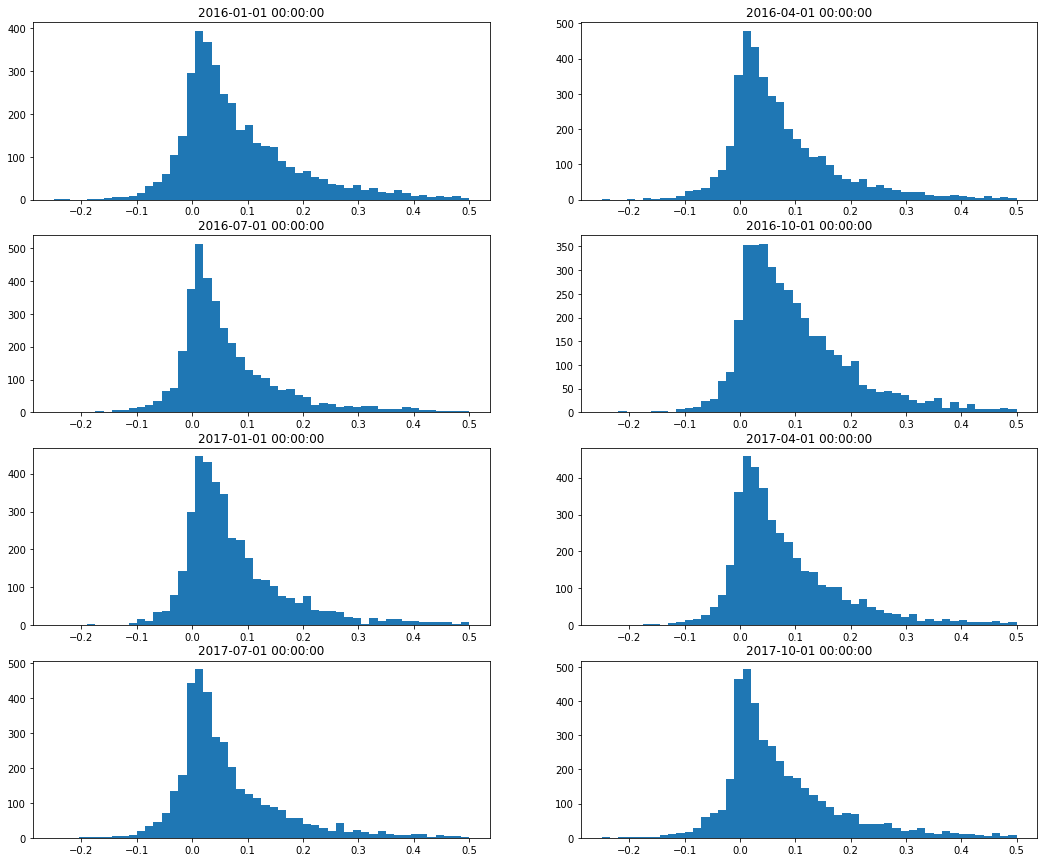

In [7]:
dts = [datetime.datetime(2016,1,1), datetime.datetime(2016,4,1), datetime.datetime(2016,7,1), datetime.datetime(2016,10,1),
       datetime.datetime(2017,1,1), datetime.datetime(2017,4,1), datetime.datetime(2017,7,1), datetime.datetime(2017,10,1)]

tmp_df = train_X["label_high_20"].copy()
tmp_df["target"] = train_y["label_high_20"]

tmp_datas = []

for i in range(len(dts)):
    try:
        tmp = tmp_df["target"][(tmp_df.index >= dts[i]) & (tmp_df.index<dts[i+1])]
    except:
        tmp = tmp_df["target"][tmp_df.index >= dts[i]]
    tmp_datas.append(tmp)

plot_hist(tmp_datas, dts)

## 図2.重ね合わせ
上図を見ると概ね同じような分布に見えますが、重ねてじっくりと観察すると分布が異なることに気付きます。例えば2016年10月～12月と、2017年7月～9月の分布を重ねてみると、その分布の違いが顕著に分かります。

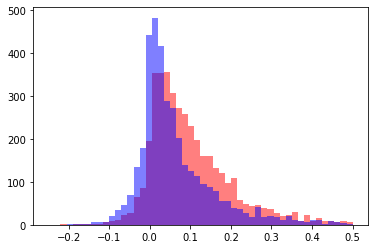

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(tmp_datas[3], bins=50, color='red', alpha=0.5, range=(-0.25, 0.5))
ax.hist(tmp_datas[6], bins=50, color='blue',alpha=0.5, range=(-0.25, 0.5))
fig.show()

予測対象の分布が時系列を経て異なるということは、「定常性がない」ことを意味します。チュートリアルでも定常性を意識することが強調されています。

株式市場のデータ分析では、可能な限り定常性を持つデータに近づけるため、特定の期間において銘柄のデータを集計することで、時系列を隔てたデータの分布形状を合わせることが一般的です。これをクロスセクションでの調整と呼びます。

具体的には、各期間のそれぞれにおいてデータを正規化することが一般的です。ただし、今回labelの分布形状は正規分布ではありませんので、関数を使って正規分布に近い形状に変換してから正規化したり、ランク化してから正規化することが考えられます。

In [22]:
dts = [datetime.datetime(2016,1,1), datetime.datetime(2016,4,1), datetime.datetime(2016,7,1), datetime.datetime(2016,10,1),
       datetime.datetime(2017,1,1), datetime.datetime(2017,4,1), datetime.datetime(2017,7,1), datetime.datetime(2017,10,1)]

tmp_df = train_X["label_high_20"].copy()
tmp_df["target"] = train_y["label_high_20"]

tmp_datas = []

for i in range(len(dts)):
    try:
        tmp = tmp_df["target"][(tmp_df.index >= dts[i]) & (tmp_df.index<dts[i+1])]
    except:
        tmp = tmp_df["target"][tmp_df.index >= dts[i]]
    tmp = (tmp - tmp.mean())/tmp.std()
    tmp_datas.append(tmp)

adjusted_label = pd.concat(tmp_datas)

ただし注意したいのは、上記のように定常性を向上したlabelをもとに訓練することが望ましいですが、評価スコアの計算は生のlabelを用いるため、train、val、testデータでのスコアは悪化する可能性があります。

一方で、汎化性能は改善している可能性が高くなります。実際のコンペの評価はtrain、val、testデータの条件とは異なり、未来における限定された期間で行われるため、定常性を向上したラベルと同じような条件となり改善する可能性があります。